# **E-mail Spam Detection using Random Forest Classifier**

## **Introduction**
Email spam, unsolicited and unwanted emails, has become a significant problem in today's digital age. It can be time-consuming, annoying, and even harmful, as spam emails often contain malicious links or attachments. To address this issue, various techniques have been developed to identify and filter spam emails. One such technique is machine learning, which can be used to train models to accurately classify emails as spam or legitimate.

In this project, we will explore the use of a Random Forest classifier to detect spam emails. Random Forest is a powerful ensemble learning algorithm that combines multiple decision trees to make accurate predictions.

### **1. Import the necessary libraries**

In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **2. Loading the dataset**
* Dataset is loaded from the current working directory.

* By hardcoding the path in `pd.read_csv()` will load the `.csv` file from the provided directory.

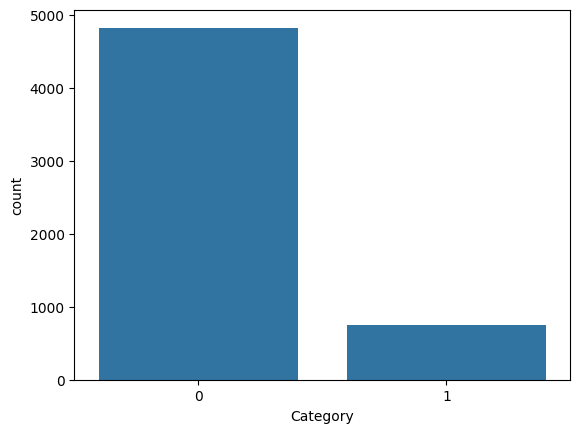

In [2]:
data = pd.read_csv('/content/modified_file.csv')
data.head()
sns.countplot(x='Category', data=data)
plt.show()

### **2.1 Handling datasets**
* Due to imbalenced dataset, we downsample the data fo better balancing.

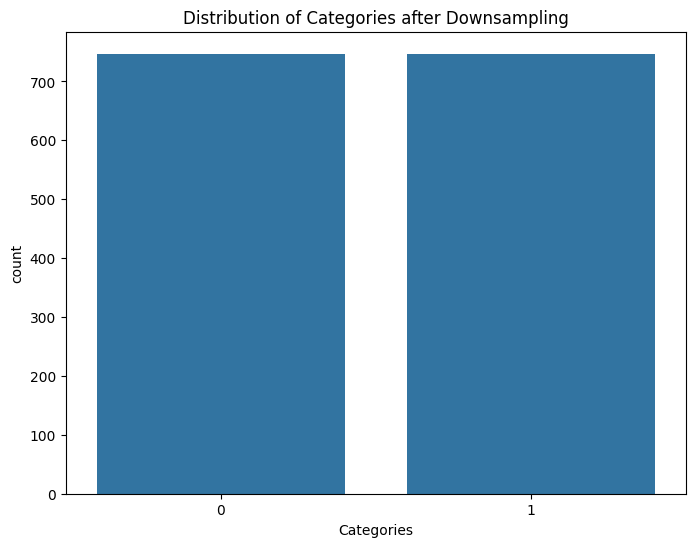

In [3]:
# Assuming "Category" takes values 0 (majority) and 1 (minority)
ham_msg = data[data.Category == 0]
spam_msg = data[data.Category == 1]
ham_msg_downsampled = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combining the downsampled data
balanced_data = pd.concat([ham_msg_downsampled, spam_msg], ignore_index=True)
balanced_data = balanced_data.dropna(subset=['Message']).reset_index(drop=True)

# Plotting the counts of the balanced dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='Category', data=balanced_data)

# Adjust title and x-axis label based on your actual categories
plt.title('Distribution of Categories after Downsampling')  # Modify if needed
plt.xlabel('Categories')  # Modify if needed
plt.show()

### **Data consistency**
* Ensure the data remains consistent after the downsampling

In [4]:
# Ensure that the 'text' column is of string type
balanced_data['Message'] = balanced_data['Message'].astype(str)

# Remove 'Subject' from the 'text' column
balanced_data['Message'] = balanced_data['Message'].str.replace('Subject', '', case=False)

balanced_data.head()

,Category,Message
0,0,If i not meeting ü all rite then i'll go home ...
1,0,"I.ll always be there, even if its just in spir..."
2,0,"Sorry that took so long, omw now"
3,0,I thk 50 shd be ok he said plus minus 10.. Did...
4,0,Dunno i juz askin cos i got a card got 20% off...


### **3. Text Processing**
Textual data is highly unstructured and need to be sandardized by:
* Removing Stopwords
* Removing Punctuations
* Performing Stemming or Lemmatization

In [5]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['Message']= balanced_data['Message'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Category,Message
0,0,If i not meeting ü all rite then ill go home l...
1,0,Ill always be there even if its just in spirit...
2,0,Sorry that took so long omw now
3,0,I thk 50 shd be ok he said plus minus 10 Did ü...
4,0,Dunno i juz askin cos i got a card got 20 off ...


In [24]:
# function to remove stop words
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['Message'] = balanced_data['Message'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Category,Message
0,0,meeting ü rite ill go home lor ü dun feel like...
1,0,ill always even spirit ill get bb soon trying ...
2,0,sorry took long omw
3,0,thk 50 shd ok said plus minus 10 ü leave line ...
4,0,dunno juz askin cos got card got 20 4 salon ca...


### **3.1 Word Cloud**
A word cloud is a text visualization tool that help's to get insights into frequently used words that are present in the corpus of the data.

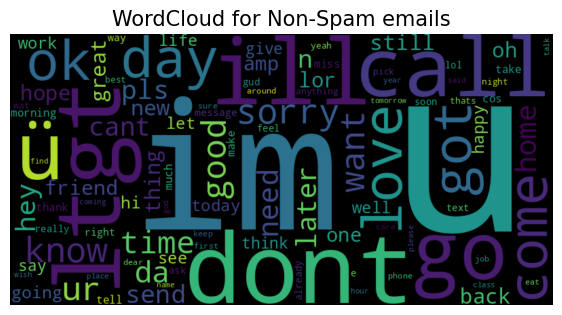

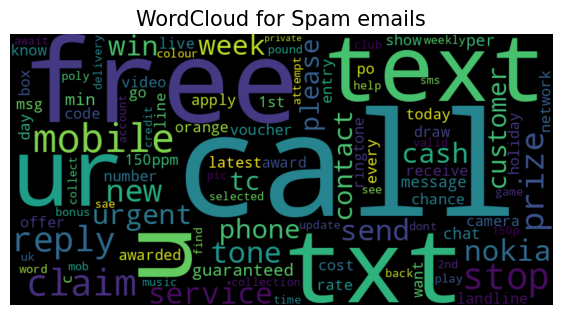

In [7]:
def plot_word_cloud(data, typ):
  # Filter for non-empty text
  data_filtered = data[data['Message'].notna()]  # Filter out rows with NaN in 'text'
  email_corpus = " ".join(data_filtered['Message'])

  plt.figure(figsize=(7, 7))

  wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

  plt.imshow(wc, interpolation='bilinear')
  plt.title(f'WordCloud for {typ} emails', fontsize=15)
  plt.axis('off')
  plt.show()

plot_word_cloud(balanced_data[balanced_data['Category'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['Category'] == 1], typ='Spam')


### **4. Word to Vector conversion**
* A machine learning model cannot be fed words directly.Therefore, the words are vectorized with the token IDs to the corresponding words, followed by padding with textual data, where the data can finally be fed to the model.

In [8]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['Message'],
													balanced_data['Category'],
													test_size = 0.2,
													random_state = 42)

In [9]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                 maxlen=max_len,
                                 padding='post',
                                 truncating='post')
test_sequences = pad_sequences(test_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')

### **5. Model Development and Evaluation**
A sequential model is implemened containing the following parts:
* Three Embedding Layers that learn featured vector representations of the input vectors.
* LSTM layer to identify useful patterns in the sequence.
* One fully connected layer.
* Output layer providing probabilities for the two classes.

In [16]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_len),  # Increased output_dim
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.5),  # Added Dropout for regularization
    tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Print the model summary
# model.summary()

While compiling a model we provide these three essential parameters:

* optimizer - optimizes the cost function using gradient descent.
* loss - used to monitor whether the model is improving with training or not.
* metrics - used to evaluate the model by predicting the training and the validation data.

In [18]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [19]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)

### **5.1 Model Training**

In [23]:
# Train the model for 20 epochs
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5250 - loss: 0.6918 - val_accuracy: 0.5151 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.4802 - loss: 0.6954 - val_accuracy: 0.4849 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4981 - loss: 0.6943 - val_accuracy: 0.4849 - val_loss: 0.6944 - learning_rate: 0.0010


In [14]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4972 - loss: 0.6932
Test Loss : 0.6930524706840515
Test Accuracy : 0.5150501728057861


### **6. Output**
With the trained model, graph can be ploted depicting the variance of training and validation accuracies with the number of epochs.

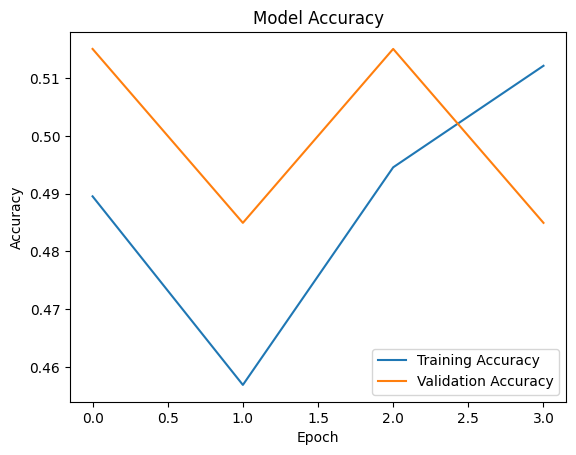

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()